In [24]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

In [25]:
img = Image.open('cat.jpg')

w, h = img.size
scale_factor = 4
img = img.resize((w//scale_factor, h//scale_factor))

img_array = np.array(img, dtype=np.float32)

print(f"Размер изображения: {img.size}")
print(f"Размер массива: {img_array.shape}")

Размер изображения: (240, 320)
Размер массива: (320, 240, 3)


Изображение преобразовано в оттенки серого
Размер серого массива: (320, 240)


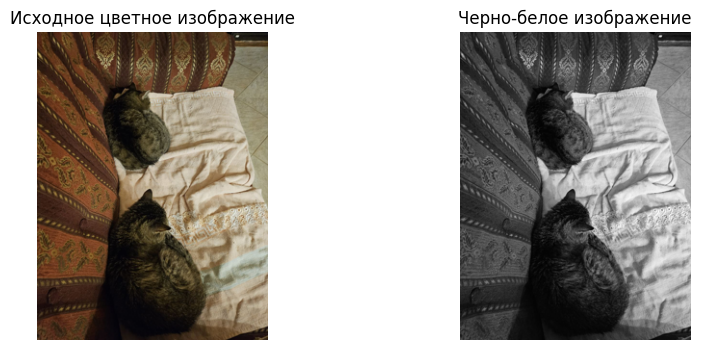

In [26]:
if len(img_array.shape) == 3:
    gray_array = np.mean(img_array, axis=2)
    print(f"Изображение преобразовано в оттенки серого")
    print(f"Размер серого массива: {gray_array.shape}")
else:
    gray_array = img_array

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Исходное цветное изображение')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gray_array, cmap='gray')
plt.title('Черно-белое изображение')
plt.axis('off')
plt.show()

In [27]:
U, S, V = np.linalg.svd(gray_array, full_matrices=False)

print(f"Размер матрицы U: {U.shape}")
print(f"Размер матрицы S: {S.shape}")
print(f"Размер матрицы V: {V.shape}")
print(f"Количество сингулярных значений: {len(S)}")
print(f"Первые 5 сингулярных значений: {S[:5]}")
print(f"Последние 5 сингулярных значений: {S[-5:]}")

Размер матрицы U: (320, 240)
Размер матрицы S: (240,)
Размер матрицы V: (240, 240)
Количество сингулярных значений: 240
Первые 5 сингулярных значений: [27202.822   5285.0703  3537.2627  2376.553   2122.399 ]
Последние 5 сингулярных значений: [14.229424 13.582241 12.605935 12.033186 10.94932 ]


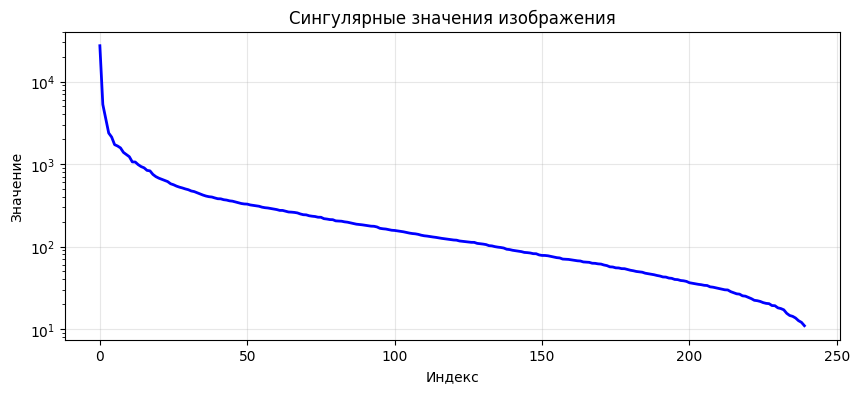

In [28]:
plt.figure(figsize=(10, 4))
plt.plot(S, 'b-', linewidth=2)
plt.title('Сингулярные значения изображения')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

In [29]:
def reconstruct_image(k):
    """Восстановление изображения с использованием k сингулярных значений"""
    S_k = np.diag(S[:k])
    U_k = U[:, :k]
    V_k = V[:k, :]
    
    reconstructed = np.dot(U_k, np.dot(S_k, V_k))
    
    reconstructed = np.clip(reconstructed, 0, 255)
    
    return reconstructed.astype(np.uint8)

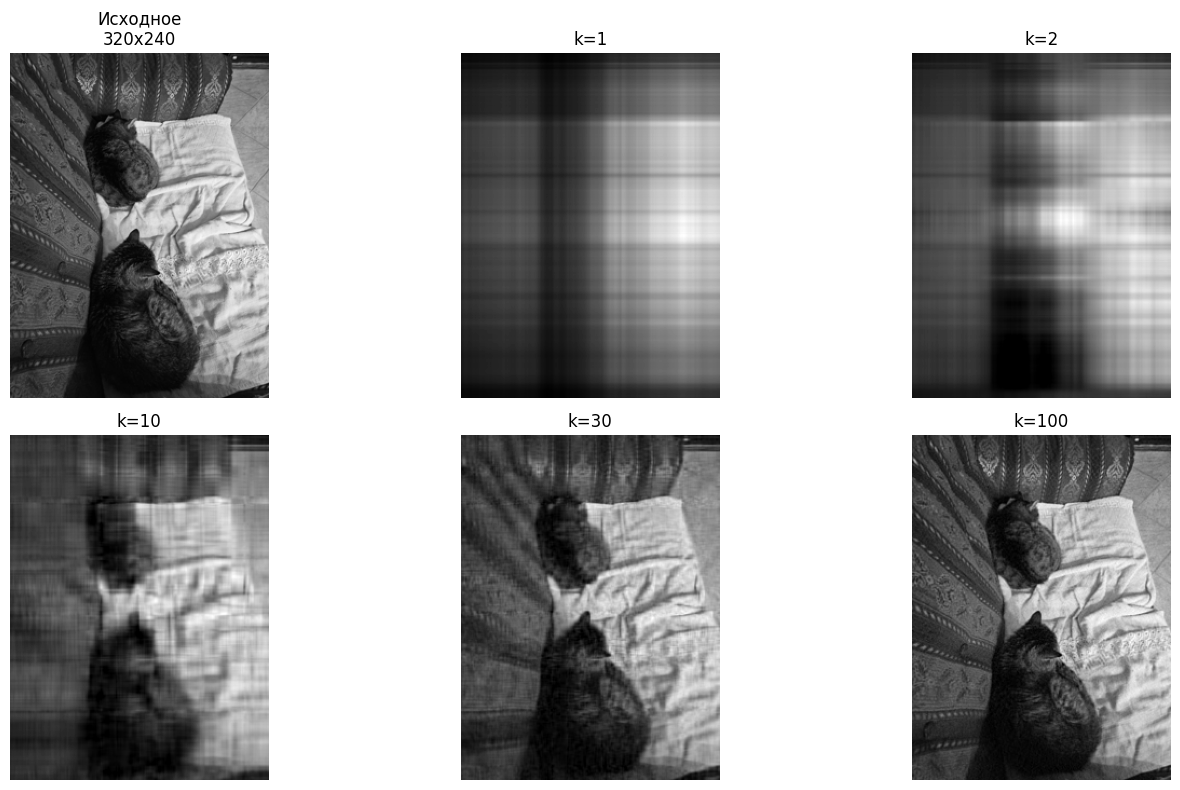

In [30]:
k_values = [1, 2, 10, 30, 100]

results = []

plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
plt.imshow(gray_array, cmap='gray')
plt.title(f'Исходное\n{gray_array.shape[0]}x{gray_array.shape[1]}')
plt.axis('off')

for i, k in enumerate(k_values):
    reconstructed_img = reconstruct_image(k)
    
    img_pil = Image.fromarray(reconstructed_img, 'L')
    filename = f'compressed_k{k}.png'
    img_pil.save(filename)
    
    compressed_bytes = os.path.getsize(filename)
    
    results.append({
        'k': k,
        'image': reconstructed_img,
        'filename': filename,
        'compressed_bytes': compressed_bytes
    })
    
    plt.subplot(2, 3, i+2)
    plt.imshow(reconstructed_img, cmap='gray')
    plt.title(f'k={k}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [31]:
original_bytes = os.path.getsize('cat.jpg')

print("СРАВНЕНИЕ РАЗМЕРОВ ФАЙЛОВ")
print("="*60)
print(f"{'Метод':<15} {'k':<5} {'Размер (KB)':<15} {'Сжатие':<15}")
print("-"*60)

print(f"{'Исходный':<15} {'-':<5} {original_bytes/1024:<15.1f} {'1.0x':<15}")

for result in results:
    size_kb = result['compressed_bytes'] / 1024
    compression_ratio = original_bytes / result['compressed_bytes']
    print(f"{'SVD':<15} {result['k']:<5} {size_kb:<15.1f} {compression_ratio:<15.1f}x")


СРАВНЕНИЕ РАЗМЕРОВ ФАЙЛОВ
Метод           k     Размер (KB)     Сжатие         
------------------------------------------------------------
Исходный        -     251.0           1.0x           
SVD             1     17.9            14.0           x
SVD             2     22.0            11.4           x
SVD             10    32.5            7.7            x
SVD             30    40.0            6.3            x
SVD             100   48.0            5.2            x


In [32]:
m, n = gray_array.shape

print("\nТЕОРЕТИЧЕСКАЯ ЭКОНОМИЯ ПАМЯТИ")
print("="*60)
print(f"Размер изображения: {m}x{n} = {m*n} пикселей")
print(f"Для хранения в float32: {m*n*4} байт")
print()

for k in k_values:
    # Для хранения сжатого изображения нужно:
    # U: m×k элементов
    # S: k элементов  
    # V: k×n элементов
    total_elements = m*k + k + k*n
    bytes_needed = total_elements * 4  # float32
    
    compression_ratio = (m*n*4) / bytes_needed
    
    print(f"k={k}:")
    print(f"  Элементов для хранения: {total_elements}")
    print(f"  Байт для хранения: {bytes_needed}")
    print(f"  Коэффициент сжатия: {compression_ratio:.1f}x")


ТЕОРЕТИЧЕСКАЯ ЭКОНОМИЯ ПАМЯТИ
Размер изображения: 320x240 = 76800 пикселей
Для хранения в float32: 307200 байт

k=1:
  Элементов для хранения: 561
  Байт для хранения: 2244
  Коэффициент сжатия: 136.9x
k=2:
  Элементов для хранения: 1122
  Байт для хранения: 4488
  Коэффициент сжатия: 68.4x
k=10:
  Элементов для хранения: 5610
  Байт для хранения: 22440
  Коэффициент сжатия: 13.7x
k=30:
  Элементов для хранения: 16830
  Байт для хранения: 67320
  Коэффициент сжатия: 4.6x
k=100:
  Элементов для хранения: 56100
  Байт для хранения: 224400
  Коэффициент сжатия: 1.4x


Для сохранения 90% энергии нужно: 1 сингулярных значений
Для сохранения 95% энергии нужно: 3 сингулярных значений


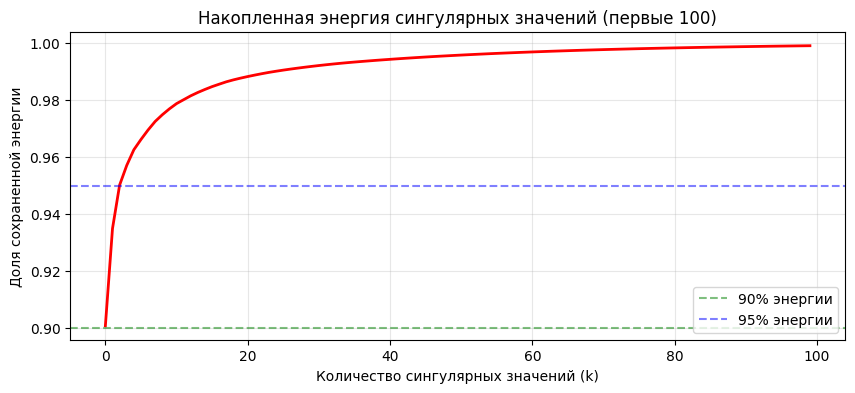

In [33]:
total_energy = np.sum(S**2)
cumulative_energy = np.cumsum(S**2) / total_energy

plt.figure(figsize=(10, 4))
plt.plot(cumulative_energy[:100], 'r-', linewidth=2)
plt.title('Накопленная энергия сингулярных значений (первые 100)')
plt.xlabel('Количество сингулярных значений (k)')
plt.ylabel('Доля сохраненной энергии')
plt.grid(True, alpha=0.3)

plt.axhline(y=0.9, color='g', linestyle='--', alpha=0.5, label='90% энергии')
plt.axhline(y=0.95, color='b', linestyle='--', alpha=0.5, label='95% энергии')
plt.legend()

k_90 = np.argmax(cumulative_energy >= 0.9) + 1
k_95 = np.argmax(cumulative_energy >= 0.95) + 1

print(f"Для сохранения 90% энергии нужно: {k_90} сингулярных значений")
print(f"Для сохранения 95% энергии нужно: {k_95} сингулярных значений")

plt.show()